# [CDAF] Atividade 1

## Nome e matrícula
Nome: João Antonio Oliveira Pedrosa
Matrícula: 2019006752

## Introdução
Nesta atividade, vamos revisar os conceitos aprendidos em sala de aula sobre aleatoriedade e previsão, trabalhando em cima do dataset do Soccer Prediction Challenge, disponível no Moodle.

In [135]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam

## Questão 1
- Carregue o dataset 'TrainingSet_2023_02_08'
- Crie um histograma para a quantidade de gols marcados por jogo do time da casa, do time fora, de gols totais e da diferença de gols por partida.
- Caso hajam instâncias com valores nitidamente errados, destaque-os e remova-os antes de gerar os histogramas.
- Calcule o mínimo, o máximo e a média de cada um dos 4 histogramas solicitados acima.

In [2]:
t_dataset = pd.read_excel("TrainingSet_2023_02_08.xlsx")

In [105]:
def plot_and_find_stats(goals, title, allow_negative = False, flip_negative = False):
    goals = [x for x in list(goals) if int(x) == x]
    if not allow_negative: 
        goals = [x for x in list(goals) if x >= 0]
    if flip_negative:
        goals = [x if x > 0 else -x for x in list(goals)]
    
    bins = [x for x in range(min(goals),max(goals)+2)]
    plt.hist(goals, bins=bins, align="left", rwidth=0.8)
    plt.xlabel('Número de Gols')
    plt.ylabel('Frequência')
    plt.title(title)
    plt.show()
    plt.close()
    
    print("Valor Máximo:", max(goals))
    print("Valor Mínimo:", min(goals))
    print("Média:", sum(goals)/len(goals))

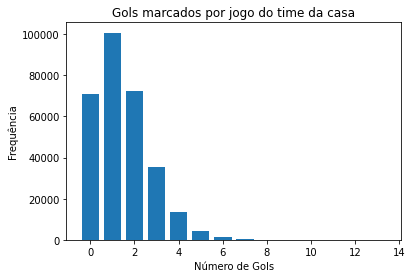

Valor Máximo: 13
Valor Mínimo: 0
Média: 1.471700194179949


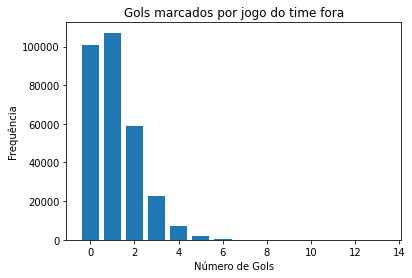

Valor Máximo: 13
Valor Mínimo: 0
Média: 1.1214410090673013


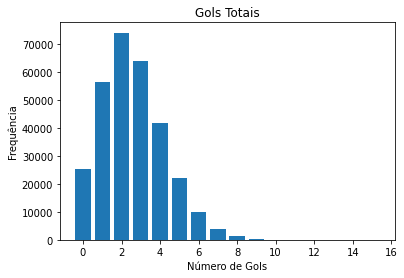

Valor Máximo: 15
Valor Mínimo: 0
Média: 2.5931412032472503


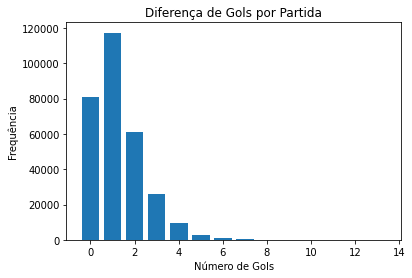

Valor Máximo: 13
Valor Mínimo: 0
Média: 1.2660035960884184


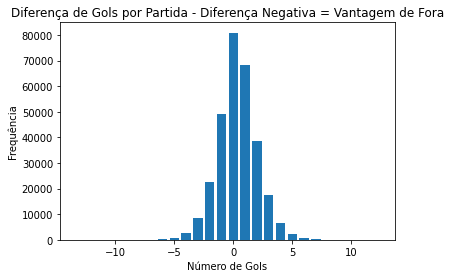

Valor Máximo: 12
Valor Mínimo: -13
Média: 0.3502509909295688


In [106]:
plot_and_find_stats(t_dataset["HS"], 'Gols marcados por jogo do time da casa')
plot_and_find_stats(t_dataset["AS"], 'Gols marcados por jogo do time fora')
plot_and_find_stats([sum(x) for x in zip(list(t_dataset["HS"]), list(t_dataset["AS"]))], 'Gols Totais')

plot_and_find_stats(t_dataset["GD"], 'Diferença de Gols por Partida', allow_negative = True, flip_negative = True)
plot_and_find_stats(t_dataset["GD"], 'Diferença de Gols por Partida - Diferença Negativa = Vantagem de Fora', allow_negative = True)

## Questão 2
- Escolha uma temporada que já terminou, de alguma das ligas presentes no dataset.
- Realize os mesmos histogramas da questão 1, mas agora para a temporada escolhida.
- Quais as diferenças entre os histogramas da questão 1 e da questão 2? O que isso pode indicar sobre a qualidade ofensiva da liga escolhida vs. o todo?

In [46]:
# Selecionando Liga e Temporada
league = "ENG1"
season = "00-01"
premier_01 = t_dataset[(t_dataset['Lge'] == league) & (t_dataset['Sea'] == season)]

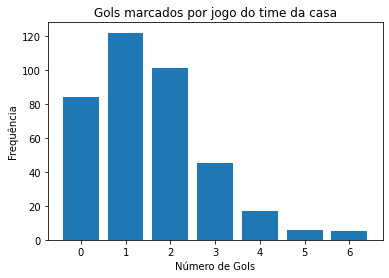

Valor Máximo: 6
Valor Mínimo: 0
Média: 1.5447368421052632


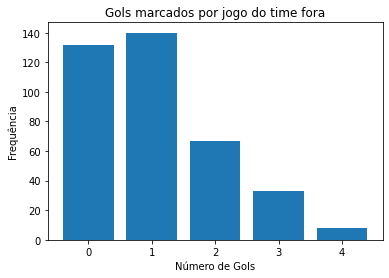

Valor Máximo: 4
Valor Mínimo: 0
Média: 1.0657894736842106


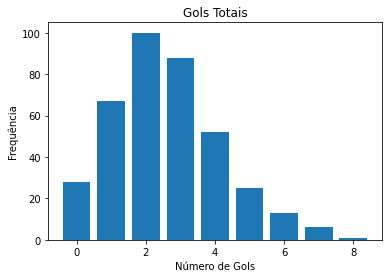

Valor Máximo: 8
Valor Mínimo: 0
Média: 2.610526315789474


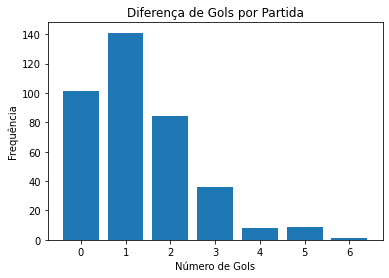

Valor Máximo: 6
Valor Mínimo: 0
Média: 1.3157894736842106


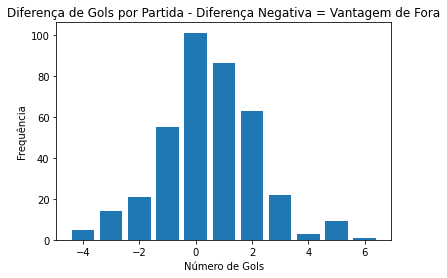

Valor Máximo: 6
Valor Mínimo: -4
Média: 0.4789473684210526


In [109]:
plot_and_find_stats(premier_01["HS"], 'Gols marcados por jogo do time da casa')
plot_and_find_stats(premier_01["AS"], 'Gols marcados por jogo do time fora')
plot_and_find_stats([sum(x) for x in zip(list(premier_01["HS"]), list(premier_01["AS"]))], 'Gols Totais')

plot_and_find_stats(premier_01["GD"], 'Diferença de Gols por Partida', allow_negative = True, flip_negative = True)
plot_and_find_stats(premier_01["GD"], 'Diferença de Gols por Partida - Diferença Negativa = Vantagem de Fora', allow_negative = True)

Apesar dos valores absolutos e máximos e mínimos diferirem bastante, as distribuições são similares.

Para os gols marcados pelo time da casa, em ambos os histogramas temos um pico em um gol e depois valores decrescentes de forma normal.

Para os gols marcados pelo time fora, em ambos os histogramas temos valores similares para 0 e 1 e depois valores decrescentes de forma normal.

A distribuição do número de gols também é similar com o todo.

Ao avaliar a diferença de gols, levando em conta números negativos, é interessante perceber que é possível visualizar estatisticamente a vantagem do time da casa.

Os valores de máximo e mínimo são os que mais diferem, mas isso não é suficiente para que possamos afirmar alguma diferença de qualidade entre as ligas ou sinal de que a Premier League é mais balanceada, pois pode ser causado simplesmente pela diferença no volume de dados, afinal, quanto menos dados, menor a chance de termos outliers (Como por exemplos goleadas absurdas com diferença de 10 ou mais gols).

## Questão 3
- À partir dos dados do campeonato em selecionado, crie um dataframe que corresponda à tabela de classificação ao fim da temporada contendo o nome dos times, nº de pontos, jogos, vitórias, empates, derrotas, gols pró, gols contra e saldo de gols. Ordena a classificação por pontos, vitórias, saldo de gols e gols pró.
- Faça o mesmo para apenas para a primeira metade de jogos.

### Função para construção

In [127]:
def create_table(matches, max_games = -1):
    matches = matches.reset_index()
    if(max_games == -1): max_games = len(matches)
    
    table = {
        team: {
            "P": 0, 
            "J": 0,
            "V": 0,
            "E": 0,
            "D": 0,
            "GP": 0,
            "GC": 0,
            "SG": 0
        }
        for team in matches["HT"].unique()
    }
    
    for i in range(max_games):
        # Retrieve ---
        team_h = matches["HT"][i]
        team_a = matches["AT"][i]
        HS = matches["HS"][i]
        AS = matches["AS"][i]
        
        # Updates ---
        # Games
        table[team_h]["J"] += 1
        table[team_a]["J"] += 1
        
        # Goals
        table[team_h]["GP"] += HS
        table[team_a]["GP"] += AS
        table[team_h]["GC"] += AS
        table[team_a]["GC"] += HS
        table[team_h]["SG"] += (HS - AS)
        table[team_a]["SG"] += (AS - HS)
        
        # Points
        if(HS > AS):
            table[team_h]["P"] += 3
            table[team_h]["V"] += 1
            table[team_a]["D"] += 1
        elif(AS > HS):
            table[team_a]["P"] += 3
            table[team_a]["V"] += 1
            table[team_h]["D"] += 1
        else:
            table[team_h]["P"] += 1
            table[team_a]["P"] += 1
            table[team_h]["E"] += 1
            table[team_a]["E"] += 1
        
    return pd.DataFrame.from_dict(table).T.sort_values(by=["P", "V", "SG", "GP"], ascending = False)

## Tabela com todos os jogos

In [128]:
create_table(premier_01)

,P,J,V,E,D,GP,GC,SG
Manchester United,80,38,24,8,6,79,31,48
Arsenal,70,38,20,10,8,63,38,25
Liverpool,69,38,20,9,9,71,39,32
Leeds United,68,38,20,8,10,64,43,21
Ipswich Town,66,38,20,6,12,57,42,15
Chelsea,61,38,17,10,11,68,45,23
Sunderland,57,38,15,12,11,46,41,5
Aston Villa,54,38,13,15,10,46,43,3
Charlton Athletic,52,38,14,10,14,50,57,-7
Southampton,52,38,14,10,14,40,48,-8


## Tabela até metade do campeonato

In [133]:
create_table(premier_01, max_games = len(premier_01)//2)

,P,J,V,E,D,GP,GC,SG
Manchester United,43,19,13,4,2,46,14,32
Arsenal,38,20,11,5,4,36,19,17
Leicester City,35,20,10,5,5,23,21,2
Liverpool,33,19,10,3,6,37,24,13
Ipswich Town,33,19,10,3,6,27,20,7
Sunderland,32,19,9,5,5,19,18,1
Aston Villa,29,18,7,8,3,23,17,6
Newcastle United,27,19,8,3,8,20,24,-4
Chelsea,26,19,7,5,7,35,25,10
Tottenham Hotspur,26,19,7,5,7,26,27,-1


## Questão 4
- Utilizando os jogos da liga escolhida, use regressão de Poisson para criar um modelo de previsão de resultados, como visto nos slides em sala e no Soccermatics.
-- https://soccermatics.readthedocs.io/en/latest/gallery/lesson5/plot_SimulateMatches.html
- Dê print no sumário do ajuste
- Simule a partida entre o 1º e o 4º colocado, onde o 1º joga em casa. Primeiro, apresente a quantidade esperada de gols de cada time. Em seguida, apresente um histograma com a probabilidade de diferentes placares entre os times.

#### Construindo o Modelo

In [137]:
# Filtering Premier League
premier = t_dataset[(t_dataset['Lge'] == "ENG1")]

# Building Model
goal_model_data = pd.concat([premier[['HT','AT','HS']].assign(home=1).rename(
            columns={'HT':'team', 'AT':'opponent','HS':'goals'}),
           premier[['AT','HT','AS']].assign(home=0).rename(
            columns={'AT':'team', 'HT':'opponent','AS':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data,
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                17138
Model:                            GLM   Df Residuals:                    17048
Model Family:                 Poisson   Df Model:                           89
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24729.
Date:                Wed, 12 Apr 2023   Deviance:                       19630.
Time:                        21:06:54   Pearson chi2:                 1.72e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1333
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.2442      0.043      5.680      0.000       0.160       0.329
team[T.Aston Villa]                 -0.4331      0.042    -10.353      0.000      -0.515      -0.351
team[T.Birmingham City]             -0.5793      0.066     -8.831      0.000      -0.708      -0.451
team[T.Blackburn Rovers]            -0.3923      0.051     -7.742      0.000      -0.492      -0.293
team[T.Blackpool]                   -0.2291      0.137     -1.669      0.095      -0.498       0.040
team[T.Bolton]                      -0.4359      0.052     -8.455      0.000      -0.537      -0.335
team[T.Bournemouth]                 -0.4066      0.067     -6.062      0.000      -0.538      -0.275
team[T.Bradford]                    -0.8476      0.185     -4.590      0.000      -1.209      -0.486
team[T.Brentford]                   -0.2808      0.113     -2.490      0.013      -0.502      -0.060
team[T.Brighton]                    -0.5400      0.071     -7.606      0.000      -0.679      -0.401
team[T.Burnley]                     -0.6303      0.063     -9.999      0.000      -0.754      -0.507
team[T.Cardiff City]                -0.7636      0.126     -6.075      0.000      -1.010      -0.517
team[T.Charlton Athletic]           -0.4785      0.063     -7.600      0.000      -0.602      -0.355
team[T.Chelsea]                     -0.0361      0.036     -1.014      0.311      -0.106       0.034
team[T.Coventry City]               -0.6720      0.169     -3.977      0.000      -1.003      -0.341
team[T.Crystal Palace]              -0.5116      0.054     -9.542      0.000      -0.617      -0.407
team[T.Derby County]                -0.8396      0.109     -7.736      0.000      -1.052      -0.627
team[T.Everton]                     -0.3562      0.039     -9.131      0.000      -0.433      -0.280
team[T.Fulham]                      -0.4975      0.046    -10.759      0.000      -0.588      -0.407
team[T.Huddersfield Town]           -1.0408      0.144     -7.239      0.000      -1.323      -0.759
team[T.Hull City]                   -0.6567      0.078     -8.367      0.000      -0.811      -0.503
team[T.Ipswich Town]                -0.3692      0.104     -3.535      0.000      -0.574      -0.164
team[T.Leeds United]                -0.2729      0.059     -4.587      0.000      -0.389      -0.156
team[T.Leicester City]              -0.2813      0.048     -5.916      0.000      -0.375      -0.188
team[T.Liverpool]                   -0.0388      0.036     -1.088      0.276      -0.109       0.031
team[T.Manchester City]             -0.0037      0.036     -0.103      0.918      -0.074       0.066
team[T.Manchester United]           -0.0113      0.035     -0.319      0.750      -0.081       0.058
team[T.Middlesbrough]               -0.5249      0.05

In [138]:
home_team='Manchester United'
away_team='Leeds United'

#Predict for Arsenal vs. Manchester City
home_score_rate=poisson_model.predict(pd.DataFrame(data={'team': home_team, 'opponent': away_team,
                                       'home':1},index=[1]))
away_score_rate=poisson_model.predict(pd.DataFrame(data={'team': away_team, 'opponent': home_team,
                                       'home':0},index=[1]))
print(home_team + ' against ' + away_team + ' expect to score: ' + str(home_score_rate))
print(away_team + ' against ' + home_team + ' expect to score: ' + str(away_score_rate))

#Lets just get a result
home_goals=np.random.poisson(home_score_rate)
away_goals=np.random.poisson(away_score_rate)
print(home_team + ': ' + str(home_goals[0]))
print(away_team + ': '  + str(away_goals[0]))

Manchester United against Leeds United expect to score: 1    2.384812
dtype: float64
Leeds United against Manchester United expect to score: 1    0.877223
dtype: float64
Manchester United: 4
Leeds United: 0


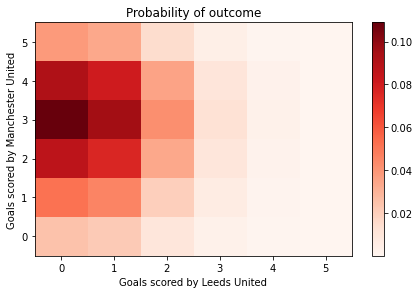

Homewin: 0.6734468860894294 
Draw: 0.17149639623497287 
Awaywin: 0.12000117768570527


In [144]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam,
                                                           'opponent': awayTeam, 'home': 1},
                                                     index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam,
                                                           'opponent': homeTeam, 'home': 0},
                                                     index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals + 1)] for team_avg in
                 [home_goals_avg, away_goals_avg]]
    return (np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

#Fill in the matrix
max_goals=5
score_matrix=simulate_match(poisson_model, home_team, away_team,max_goals)

fig=plt.figure()
ax=fig.add_subplot(1,1,1)
pos=ax.imshow(score_matrix, extent=[-0.5,max_goals+0.5,-0.5,max_goals+0.5], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of outcome')
plt.xlim((-0.5,5.5))
plt.ylim((-0.5,5.5))
plt.tight_layout()
ax.set_xlabel('Goals scored by ' + away_team)
ax.set_ylabel('Goals scored by ' + home_team)
plt.show()

#Home, draw, away probabilities
homewin=np.sum(np.tril(score_matrix, -1))
draw=np.sum(np.diag(score_matrix))
awaywin=np.sum(np.triu(score_matrix, 1))

print("Homewin:", homewin, "\nDraw:", draw, "\nAwaywin:", awaywin)

## Questão 5
- Utilize o modelo treinado para simular os placares esperados de todos os jogos da temporada.
- Construa uma tabela de classificação em cima dos resultados esperados. Considere que jogos com uma diferença esperada de gols < 0.5 é um empate.
- Compare a tabela real com a simulada. Onde estão as principais diferenças entre elas? E similaridades? O que isso pode indicar em termos de o que modelo subestima e superestima sobre a qualidade dos times?

In [145]:
def probable_outcome(team_home, team_away, model=poisson_model):
    probs = simulate_match(model, team_home, team_away)
    
    best = 0.0
    a = -1
    b = -1
    for i in range(len(probs)):
        for j in range(len(probs[i])):
            if probs[i][j] > best:
                best = probs[i][j]
                a = i
                b = j
    
    return a, b
# def simulate_championship(matches):
    

In [171]:
def predict_championship(matches, max_games = -1):
    matches = matches.reset_index()
    if(max_games == -1): max_games = len(matches)
    
    table = {
        team: {
            "P": 0, 
            "J": 0,
            "V": 0,
            "E": 0,
            "D": 0,
            "GP": 0,
            "GC": 0,
            "SG": 0
        }
        for team in matches["HT"].unique()
    }
    
    for i in range(max_games):
        # Retrieve ---
        team_h = matches["HT"][i]
        team_a = matches["AT"][i]
        HS, AS = probable_outcome(team_h, team_a)
        
        # Updates ---
        # Games
        table[team_h]["J"] += 1
        table[team_a]["J"] += 1
        
        # Goals
        table[team_h]["GP"] += HS
        table[team_a]["GP"] += AS
        table[team_h]["GC"] += AS
        table[team_a]["GC"] += HS
        table[team_h]["SG"] += (HS - AS)
        table[team_a]["SG"] += (AS - HS)
        
        # Points
        if(HS > AS):
            table[team_h]["P"] += 3
            table[team_h]["V"] += 1
            table[team_a]["D"] += 1
        elif(AS > HS):
            table[team_a]["P"] += 3
            table[team_a]["V"] += 1
            table[team_h]["D"] += 1
        else:
            table[team_h]["P"] += 1
            table[team_a]["P"] += 1
            table[team_h]["E"] += 1
            table[team_a]["E"] += 1
        
    return pd.DataFrame.from_dict(table).T.sort_values(by=["P", "V", "SG", "GP"], ascending = False)

#### Simulando a Premier League 2000/01

In [173]:
pred_premier_01 = predict_championship(premier_01)
pred_premier_01

,P,J,V,E,D,GP,GC,SG
Chelsea,88,38,25,13,0,52,13,39
Manchester United,84,38,23,15,0,53,15,38
Liverpool,78,38,20,18,0,52,18,34
Arsenal,76,38,19,19,0,54,19,35
Manchester City,74,38,18,20,0,53,20,33
Tottenham Hotspur,64,38,14,22,2,40,25,15
Everton,53,38,10,23,5,34,29,5
Ipswich Town,47,38,7,26,5,33,36,-3
Leicester City,45,38,6,27,5,35,37,-2
Aston Villa,43,38,7,22,9,29,36,-7


#### Comentários

O modelo conseguiu acertar dois dos três rebaixados!

É possível perceber uma disparidade grande nos números de pontos, principalmente dos 2 últimos colocados.

O Manchester City, time de tradição, foi rebaixado no campeonato real enquanto na simulação aparece em quinto colocado.

Acredito que a principal falha seja que o modelo tende a superestimar muito os times de tradição. Como as simulações são determinísticas e baseadas em históricos passados, em nenhum momento um time pouco tradicional como o Leeds United irá ganhar de um time de tradição como o Liverpool, o que na realidade irá acontecer. É possível reparar, inclusive, que a classificação do campeonato simulado é quase um ranking de quão tradicional um time é. O modelo também não leva em conta a tendência atual de um time, que pode estar em boa ou má fase.

Uma possível maneira interessante de tentar diminuir esse problema seria adicionar um fator de aleatoriedade ao invés de sempre escolher o resultado mais provável.